# **CRDM Beta Simulation (CCB Project): Version 3**

#### Softmax vs Luce Choice Models
#### - Alpha [0.3, 1.2, 0.05] vs alpha constant [0.6]
#### - Beta [-1.3, 1.31, 2.6/498], obtaining 500 steps (*simulated subjects*)
#### - Gamma constant [1.5] (**Softmax**)
#### - Mu constant [0.5] (**Luce**)

##### **Version 3 Improvements** 
- Narrows ALPHA range to more reasonable bounds [ 0.3, 1.2, 0.05]
- Narrows BETA range to more reasonable bounds   [-1.3, 1.31, 2.6/498]
- ***Compares Softmax and Luce Choice Models***

## Why use our own math for obtaining LL rather than using Scipy's Bernoulli logpmf?

- So we can have a better understanding of the mathematical processes of our modeling
    - Lets everyone know what's actually happening! Couldn't find docs explaining the "efficiency mechanics" of Bernoulli's logpmf, so let's investigate compare the LL outcomes:
    - Returns identical summed LL
        - log(x) * y == log(x**y)
            - If you multiply a logged value by another value (*left*), it's the same as if you exponentiated before logging (*right*)
                - *Logs are used to get the exponent required for the base to reach the input value*
                    - z = log_e(x) --> e**z = x
                        - z * y = y * log_e(x) --> e**(z*y) = x**y
                            - z * y = log_e(x**y)
        - x = prob of choosing lottery for the current condition subgroup
        - y <= number of trials per subgroup
        - Can be represented as log(x) + log(x) == 2 * log(x)
            - log(x) was originally part of log(x**2)
        - *Works regardless of number of trials per subgroup*
    - Bernoulli:
        - log(x) + log(x) + log(x[y number of times])
    - Manual:
        - log(x) * y

In [1]:
"""
===================
Mandy Renfro (2024)
===================
"""

from glob import glob
import numpy as np
np.seterr(all = "ignore")
import os
import os.path, sys
import pandas as pd
import pylab as plt
import seaborn as sns
sns.set_theme(style = "white", palette = "muted")
from scipy.stats import linregress, shapiro, spearmanr
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [7]:
import numpy as np
from scipy.stats import bernoulli

trials = np.array([1.0, 1.0, 0.0]) ## each value represents sum of lottery choices in that condition subgroup | number of trials per subgroup in this example = 1
probs  = np.array([1.0, 0.5, 0.7]) ## probability (predictive - not proportion) Ss will chose lottery for each condition subgroup
print("No black box LL:    ", np.nansum(np.log(probs) * trials + np.log(1 - probs) * (1 - trials)))
print("Bernoulli logpmf LL:", np.nansum(bernoulli.logpmf(trials, probs)))

No black box LL:     -1.8971199848858813
Bernoulli logpmf LL: -1.8971199848858813


In [8]:
import numpy as np
from scipy.stats import bernoulli

MLL_trials = np.array([2.0, 1.0, 1.0]) ## (y) each value represents the sum of lottery choices in that condition subgroup | number of trials per subgroup = 2
MLL_probs  = np.array([1.0, 0.5, 0.7]) ## (p) probability (predictive - not proportion) Ss will chose lottery for each condition subgroup
MLL_total_trials = np.array([2, 2, 2]) ## (previously 1) number of trials per subgroup
print("No black box LL:    ", np.nansum(np.log(MLL_probs) * MLL_trials + np.log(1 - MLL_probs) * (MLL_total_trials - MLL_trials)))

BLL_trials = np.array([1.0, 1.0, 0.0, 1.0, 1.0, 0.0])
BLL_probs  = np.array([1.0, 1.0, 0.5, 0.5, 0.7, 0.7])
print("Bernoulli logpmf LL:", np.nansum(bernoulli.logpmf(BLL_trials, BLL_probs)))

No black box LL:     -2.946942109384559
Bernoulli logpmf LL: -2.946942109384559


In [11]:
## uses relative path to find mandy_module.py file -- needs to be customized per folder
sys.path.insert(0, os.path.abspath("../../utilities/")) 
from mandy_module import lookup_code
from scipy.stats import bernoulli
from scipy.optimize import minimize

#lookup_code(bernoulli.logpmf)
lookup_code(minimize)

def minimize(fun, x0, args=(), method=None, jac=None, hess=None,
             hessp=None, bounds=None, constraints=(), tol=None,
             callback=None, options=None):
    """Minimization of scalar function of one or more variables.

    Parameters
    ----------
    fun : callable
        The objective function to be minimized.

            ``fun(x, *args) -> float``

        where ``x`` is a 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where ``n`` is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of

            - 'Nelder-Mead' :ref:`(see here) <optimize.minimize-neldermead>`
         

In [2]:
base_proj_dir = "Z:/data/CCB" ## base project directory
save_dir = os.path.join(base_proj_dir, "derivatives/simulations/crdm/simulation3") ## save directory for CRDM simulations
if not os.path.exists(save_dir): ## new Ss
    os.makedirs(save_dir) ## make new Ss save directory

def pd_extend(df_dest, df_extending):
    """ Concatenates all subjects dataframe for saving current Ss parameters
        INPUT:
        - df_dest: destination dataframe to which second dataframe will be appended
        - df_extending: dataframe to be added to the destination dataframe
        OUTPUT:
        - Concatenated dataframe containing info from currently iterated Ss
    """
    return pd.concat([df_dest, df_extending])

def SVs(alpha, beta, lottery_value, certain_value, ambiguity, probability):
    """ Calculate SV for lottery and safe options given the current trial condition combination (Gilboa & Schmeidler, 1989)
        *Note: np.sign() and np.abs() allows this function to flexibly handle *both* gain and loss trials
        INPUT:
        - alpha: current Ss alpha
        - beta: current Ss beta
        - lottery_value: winning lottery amount for current condition combo
        - ambiguity: ambiguity level for current condition combo
        - probability: probability for current condition combo
        OUTPUT:
        - SV_lottery: subjective value for lottery option for current trial condition combination
        - SV_certain: subjective value for certain option fr current trial condition combination
    """
    SV_lottery = (probability - beta * ambiguity / 2) * lottery_value**alpha
    SV_certain = certain_value**alpha
    return SV_lottery, SV_certain

In [14]:
n_trials_per_subgroup = 2 ## number of trials per probability/lottery combo

lottery_range = [8, 25, 40, 50] ## possible winning lottery values
certain_value = 5 ## value of safe option
## setting up variable arrays for parallel computations
ambiguities_extend   = np.array([0.24,  0.5,  0.74,     0,    0,    0,    0,    0]) ## ambiguities for all amb/prob pairing
probabilities_extend = np.array([ 0.5,  0.5,   0.5,  0.13, 0.25, 0.38, 0.50, 0.75]) ## probabilties for all amb/prob pairing
lotteries = np.array([])
ambiguities = np.array([])
probabilities = np.array([])
extend_len = len(ambiguities_extend)
for i, lott in enumerate(lottery_range): ## for each of the four possible lottery values
    lotteries = np.hstack((lotteries, np.ones(extend_len) * lott)) ## adds current lott value in quantity of ambiguities_extend (8)
    ambiguities = np.hstack((ambiguities, ambiguities_extend)) ## adds ambiguity_extend as many times as lottery_range is long (4)
    probabilities = np.hstack((probabilities, probabilities_extend)) ## adds probabilities_extend as many times as lottery_range is long (4)
total_trials = n_trials_per_subgroup * len(lotteries) ## total number of trials per pain condition
print(total_trials)

64


### Determining Alpha and Beta bounds

In [3]:
possible_alphas = []
possible_betas = []
probabilities_b = [0.13, 0.25, 0.38, 0.50, 0.75]
ambiguities_b = [0.24, 0.5, 0.74]
lottery_range = [8, 25, 40, 50]
sval = 5

for this_prob in probabilities_b:
    for this_val in lottery_range:
        possible_alphas.append(np.log(this_prob)/np.log(sval/this_val))
possible_alphas = np.array(possible_alphas)
print("ALPHA Bounds: [", np.amin(possible_alphas), ",", np.amax(possible_alphas), "]")

for this_amb in ambiguities_b:
    possible_betas.append(-1/this_amb)
    possible_betas.append(1/this_amb)
possible_betas = np.array(possible_betas)
print("BETA Bounds: [", np.amin(possible_betas), ",", np.amax(possible_betas), "]")

ALPHA Bounds: [ 0.12493873660829996 , 4.340861860579061 ]
BETA Bounds: [ -4.166666666666667 , 4.166666666666667 ]


## **Softmax Choice Model**

In [4]:
def binomial_likelihood_SM(alpha, beta, y, n,  lottery_value, certain_value, ambiguity, probability):
    """ Calculates binomial LL for each parameter combination
        *See above notes for why we can use our own math rather than rely on bernoulli.logpmf()
        *Deals with positive infinity values by assigning a value of 0. Then the MLE functions, 
        parameter pairs with a 0 LL score are removed.
        INPUT:
        - alpha: current Ss risk parameter [high values indicate risk seeking]
        - beta: current Ss ambiguity parameter [high values indicate ambiguity avoidance]
        - gamma: current Ss choice stochasticity parameter [high values indicate more noise]
        - y: summation of lottery choices in condition subgroup
        - n: number of trials per condition combo
        - lottery_value: current condition combo winning lottery amount 
        - certain_value: current condition combo certain amount
        - ambiguity: current condition combo ambiguity level
        - probability: current condition combo probability level
        OUTPUT:
        - log_likelihood: relative score representing probabilty data resulted from current parameter combo
    """
    p = probability_of_lottery_choice_SM(alpha, beta, lottery_value, certain_value, ambiguity, probability)
    log_likelihood = (np.log(p[0]) * y + np.log(1 - p[0]) * (n - y))
    log_likelihood[log_likelihood == np.inf] = 0
    return log_likelihood

def make_data_and_recover_SM(p_alpha, p_beta, pid, df):
    """ Executes parameter estimation and saves results to df_participants dataframe.
        INPUT:
        - p_alpha: current simulation Ss alpha value
        - p_beta: current simulation Ss beta value
        - pid: current simulation Ss subject ID
        - df: Ss dataframe with all previous Ss information (adds by extending current Ss df)
        OUPUT:
        - *res: recovered alpha, recovered beta
        - df: extended df_participants dataframe
    """
    pairs = []  
    all_data = None 
    for i, amb in enumerate(ambiguities):
        subset_trials = np.random.random(size = n_trials_per_subgroup) ## simulated randomness of choice
        p_true = probability_of_lottery_choice_SM(p_alpha, p_beta, lotteries[i], certain_value, amb, probabilities[i])
        idx = np.where(subset_trials <= p_true[0])
        sv_lott = p_true[1]
        sv_safe = p_true[2]
        subset_trials[:] = 0
        subset_trials[idx] = 1 ## error prone, real trials
        #subset_trials[:int(np.round(n_trials_per_subgroup*p_true))] = 1 ## perfect circumstances, no noise
        data = [pid, p_alpha, p_beta, None, None, lotteries[i], certain_value, amb, probabilities[i], sv_lott, sv_safe]
        data = [[a] * n_trials_per_subgroup for a in data]
        data.append(subset_trials)
        data = np.array(data).T
        if all_data is None:
            all_data = data
        else:
            all_data = np.vstack((all_data, data))
        lottery_chosen_x = np.sum(subset_trials)
        pairs.append((lottery_chosen_x, n_trials_per_subgroup))
    res = MLE_alpha_SM(np.array(pairs), lotteries, certain_value, ambiguities, probabilities)
    res = MLE_beta_SM(np.array(pairs), res, lotteries, certain_value, ambiguities, probabilities)
    df = pd_extend(df, pd.DataFrame(all_data, columns = df.columns))
    idx = np.where(df["Recovered Alpha"].values == None)
    df["Recovered Alpha"].values[idx] = res[0]
    df["Recovered Beta"].values[idx] = res[1]
    return *res, df

def MLE_alpha_SM(pairs, lotteries, certain_value, ambiguities, probabilities):
    """ Grid search of alpha and gamma parameter space to determine which point produces maximum log likelihood score. 
        *Risk trials only*
        *Notes: Conceptualize parameter and probability space as two parallel multidimensional spaces. 
                Using a "grid search" method, we carefully iterate through a 2D parameter space (alpha/gamma) 
                to determine which point best explains the data, quantified as the maximum likelihood score.
        INPUT:
        ** Numpy parallel arrays **
        - pairs: Ss choices for all condition subgroups
        - lotteries: winning lottery amounts for conditon subgroups
        - certain_values: certain amounts for condition subgroups
        - ambiguities: ambiguity level for condition subgroups
        - probabilities: probability level for condition subgroups
        OUTPUT:
        - Tuple containing best fit parameters (alpha and gamma)
    """
    best_fit = None
    max_likelihood = None
    y, n = pairs[:, 0], pairs[:, 1]
    idx = np.where(ambiguities == 0)
    for alpha in np.round(np.arange(0.3, 2, 0.01), 2): ## grid search - part 1 (fit alpha first)
        ## sums log likelihoods of all condition subgroups (beta held constant at 0, as is ambiguity level)
        likelihood = np.nansum(binomial_likelihood_SM(alpha, 0, y[idx], n[idx], lotteries[idx], certain_value, ambiguities[idx], probabilities[idx]))
        if max_likelihood is None or likelihood > max_likelihood:
            max_likelihood = likelihood
            best_fit = alpha
    return best_fit

def MLE_beta_SM(pairs, alpha, lotteries, certain_value, ambiguities, probabilities):
    """ Grid search of beta parameter space to determine which point produces maximum log likelihood score. 
        *Ambiguity trials only*
        *Notes: Conceptualize parameter and probability space as two parallel multidimensional spaces. 
        Using a "grid search" method previously to determine the best fit of alpha and gamma parameters,
        we can use those values to now guide our search through 1D beta space.
        INPUT:
        ** Numpy parallel arrays **
        - pairs: Ss choices for all condition subgroups
        - lotteries: winning lottery amounts for conditon subgroups
        - certain_values: certain amounts for condition subgroups
        - ambiguities: ambiguity level for condition subgroups
        - probabilities: probability level for condition subgroups
        OUTPUT:
        - Tuple containing best fit parameters (alpha, beta, and gamma)
    """
    best_fit = None
    max_likelihood = None
    y, n = pairs[:, 0], pairs[:, 1]
    idx = np.where(ambiguities != 0)
    for beta in np.round(np.arange(-1.3, 1.31, 0.01), 2): ## grid search - part 2 (fit beta second)
        ## sums log likelihoods of all condition subgroups (trials where ambiguity isn't 0)
        likelihood = np.nansum(binomial_likelihood_SM(alpha, beta, y[idx], n[idx], lotteries[idx], certain_value, ambiguities[idx], probabilities[idx]))
        if max_likelihood is None or likelihood > max_likelihood:
            max_likelihood = likelihood
            best_fit = (alpha, beta)
    return best_fit

def probability_of_lottery_choice_SM(alpha, beta, lottery_value, certain_value, ambiguity, probability, gamma = 1.5):
    """ Determines probability of selecting lottery using the Softmax probabilitic function
        INPUT:
        - alpha: current Ss risk parameter [high values indicate risk seeking]
        - beta: current Ss ambiguity parameter [high values indicate ambiguity avoidance]
        - gamma: current Ss choice stochasticity parameter [high values indicate more noise]
        - lottery_value: current condition combo winning lottery amount 
        - certain_value: current condition combo certain amount
        - ambiguity: current condition combo ambiguity level
        - probability: current condition combo probability level
        OUTPUT:
        - Ss probability of choosing lottery for trials with the current condition combo
        - SV_lottery: SV for current lottery option
        - SV_certain: SV for current safe option
    """
    SV_lottery, SV_certain = SVs(alpha, beta, lottery_value, certain_value, ambiguity, probability)
    return 1 / (1 + np.exp(-gamma * (SV_lottery - SV_certain))), SV_lottery, SV_certain

### **Softmax #1**
- Simulating across beta
- Alpha and gamma held constant (0.6, 1.5)

Shapiro-Wilk Test of Normality: (0.8850033283233643, 7.675733572269971e-19)
Spearmans Rho^2: (0.937593547751573, 1.322892630412218e-230)
Residual SD: 0.28132379849561256
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/simulation3\simulation3SM_cAvBcG-2trials.png


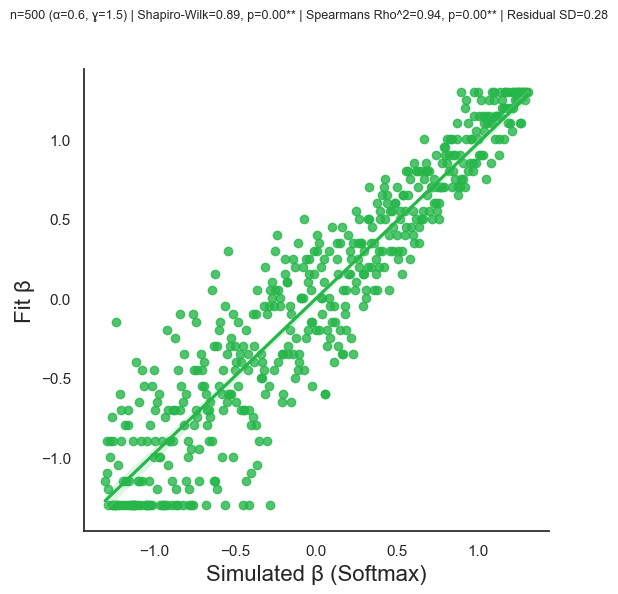

In [5]:
alphas = np.array([0.6])
betas = np.round(np.arange(-1.3, 1.31, 2.6/498), 2) ## 500 steps
print("Number of Simulations:", len(alphas)*len(betas))
df = pd.DataFrame()

df_participants = pd.DataFrame(columns=["PID", 
                                        "Simulated Alpha", "Simulated Beta", 
                                        "Recovered Alpha", "Recovered Beta", 
                                        "Lottery Value", "Safe Value", 
                                        "Ambiguity", "Probability", 
                                        "SV Lottery", "SV Safe",
                                        "Choice"])
recovered_betas = []
pid = 1
for p_alpha in alphas:
    for p_beta in betas:
        alpha_r, beta_r, df_participants = make_data_and_recover_SM(p_alpha, p_beta, pid, df_participants)
        recovered_betas.append(beta_r)
        print(pid, end = "\r")
        pid += 1   
filename = os.path.join(save_dir, "simulation3SM_cAvBcG-2trials.csv")
df_participants.to_csv(filename)

beta_x = betas.tolist() * alphas.shape[0]
fit_line = linregress(beta_x, recovered_betas)
fit_stat = spearmanr(beta_x, recovered_betas)
line_y = np.array(beta_x) * fit_line.slope + fit_line.intercept
residuals = np.array(beta_x) - np.array(recovered_betas)
print("Shapiro-Wilk Test of Normality:", shapiro(np.abs(residuals))[:])
print("Spearmans Rho^2:", fit_stat[:])
print("Residual SD:", np.std(residuals))
df["Simulated β (Softmax)"] = beta_x
df["Fit β"] = recovered_betas
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.regplot(x = "Simulated β (Softmax)", y = "Fit β", data = df, color = "#26B64A")
sns.despine(top = True)
ax.set_ylabel("Fit β", fontsize=16)
ax.set_xlabel("Simulated β (Softmax)", fontsize=16)
plt.suptitle("n={5} (α=0.6, ɣ=1.5) | Shapiro-Wilk={0:.2f}, p={1:.2f}** | Spearmans Rho^2={2:.2f}, p={3:.2f}** | Residual SD={4:.2f}".format(shapiro(np.abs(residuals))[0], 
                                                                                                                                            shapiro(np.abs(residuals))[1], 
                                                                                                                                            fit_stat[0], fit_stat[1], 
                                                                                                                                            np.std(residuals),
                                                                                                                                            len(beta_x)),
                                                                                                                                            fontsize = 9)
fig_name = os.path.join(save_dir, "simulation3SM_cAvBcG-2trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)

### **Softmax #2**
- Simulating across alpha and beta
- Gamma held constant (1.5)

Shapiro-Wilk Test of Normality: (0.8823364973068237, 9.726930248986501e-30)
Spearmans Rho^2: (0.9402943084594426, 0.0)
Residual SD: 0.27924309308512807
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/simulation3\simulation3SM_vAvBcG-2trials.png


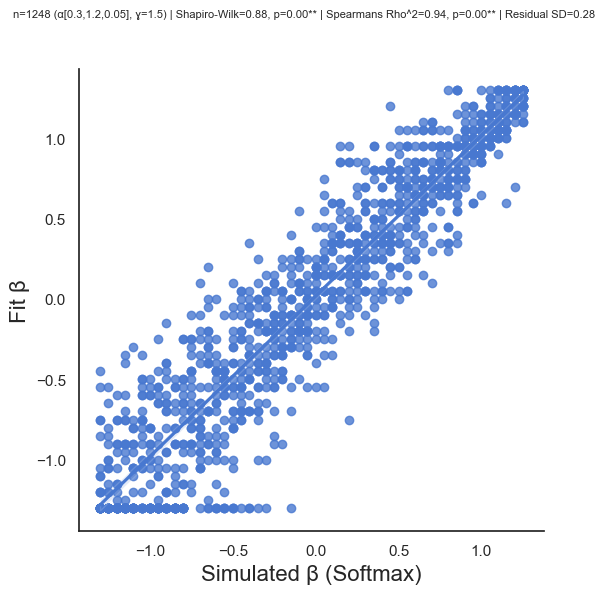

In [10]:
#alphas = np.round(np.arange(0.3,  1.2,    0.05), 2)
#betas = np.round(np.arange(-1.3, 1.31, 2.6/498), 2)
alphas = np.round(np.arange(0.3, 1.5, 0.05), 2)
betas = np.round(np.arange(-1.3, 1.3, 0.05), 2)
print("Number of Simulations:", len(alphas)*len(betas))
df = pd.DataFrame()

df_participants = pd.DataFrame(columns=["PID", 
                                        "Simulated Alpha", "Simulated Beta", 
                                        "Recovered Alpha", "Recovered Beta", 
                                        "Lottery Value", "Safe Value", 
                                        "Ambiguity", "Probability",
                                        "SV Lottery", "SV Safe", 
                                        "Choice"])
recovered_betas = []
pid = 1
for p_alpha in alphas:
    for p_beta in betas:
        alpha_r, beta_r, df_participants = make_data_and_recover_SM(p_alpha, p_beta, pid, df_participants) 
        recovered_betas.append(beta_r)
        print(pid, end = "\r")
        pid += 1     
filename = os.path.join(save_dir, "simulation3SM_vAvBcG-2trials.csv")
df_participants.to_csv(filename)

beta_x = betas.tolist() * alphas.shape[0]
fit_line = linregress(beta_x, recovered_betas)
fit_stat = spearmanr(beta_x, recovered_betas)
line_y = np.array(beta_x) * fit_line.slope + fit_line.intercept
residuals = np.array(beta_x) - np.array(recovered_betas)
print("Shapiro-Wilk Test of Normality:", shapiro(np.abs(residuals))[:])
print("Spearmans Rho^2:", fit_stat[:])
print("Residual SD:", np.std(residuals))
df["Simulated β (Softmax)"] = beta_x
df["Fit β"] = recovered_betas
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.regplot(x = "Simulated β (Softmax)", y = "Fit β", data = df)
sns.despine(top = True)
ax.set_ylabel("Fit β", fontsize=16)
ax.set_xlabel("Simulated β (Softmax)", fontsize=16)
plt.suptitle("n={5} (α[0.3,1.2,0.05], ɣ=1.5) | Shapiro-Wilk={0:.2f}, p={1:.2f}** | Spearmans Rho^2={2:.2f}, p={3:.2f}** | Residual SD={4:.2f}".format(shapiro(np.abs(residuals))[0], 
                                                                                                                                                    shapiro(np.abs(residuals))[1], 
                                                                                                                                                    fit_stat[0], fit_stat[1], 
                                                                                                                                                    np.std(residuals),
                                                                                                                                                    len(beta_x)),
                                                                                                                                                    fontsize = 8)
fig_name = os.path.join(save_dir, "simulation3SM_vAvBcG-2trials.png") 
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)

## **Luce Choice Model**

In [6]:
def binomial_likelihood_LUCE(alpha, beta, y, n, lottery_value, certain_value, ambiguity, probability):
    p = probability_of_lottery_choice_LUCE(alpha, beta, lottery_value, certain_value, ambiguity, probability)
    log_likelihood = (np.log(p[0]) * y + np.log(1 - p[0]) * (n - y))
    log_likelihood[log_likelihood == np.inf] = 0
    return log_likelihood

def make_data_and_recover_LUCE(p_alpha, p_beta, pid, df):
    pairs = []  
    all_data = None 
    for i, amb in enumerate(ambiguities):
        subset_trials = np.random.random(size = n_trials_per_subgroup)
        p_true = probability_of_lottery_choice_LUCE(p_alpha, p_beta, lotteries[i], certain_value, amb, probabilities[i])
        idx = np.where(subset_trials <= p_true[0])
        sv_lott = p_true[1]
        sv_safe = p_true[2]
        subset_trials[:] = 0
        subset_trials[idx] = 1 ## error prone, real trials
        #subset_trials[:int(np.round(n_trials_per_subgroup*p_true))] = 1 ## perfect circumstances, no noise
        data = [pid, p_alpha, p_beta, None, None, lotteries[i], certain_value, amb, probabilities[i], sv_lott, sv_safe]
        data = [[a] * n_trials_per_subgroup for a in data]
        data.append(subset_trials)
        data = np.array(data).T
        if all_data is None:
            all_data = data
        else:
            all_data = np.vstack((all_data, data))
        lottery_chosen_x = np.sum(subset_trials)
        pairs.append((lottery_chosen_x, n_trials_per_subgroup))
    res = MLE_alpha_LUCE(np.array(pairs), lotteries, certain_value, ambiguities, probabilities)
    res = MLE_beta_LUCE(np.array(pairs), res, lotteries, certain_value, ambiguities, probabilities)
    df = pd_extend(df, pd.DataFrame(all_data, columns = df.columns))
    idx = np.where(df["Recovered Alpha"].values == None)
    df["Recovered Alpha"].values[idx] = res[0]
    df["Recovered Beta"].values[idx] = res[1]
    return *res, df

def MLE_alpha_LUCE(pairs, lotteries, certain_value, ambiguities, probabilities):
    best_fit = None
    max_likelihood = None
    y, n = pairs[:, 0], pairs[:, 1]
    idx = np.where(ambiguities == 0)
    for alpha in np.round(np.arange(0.3, 2, 0.05), 2): ## grid search - part 1 (fit alpha first)
        likelihood = np.nansum(binomial_likelihood_LUCE(alpha, 0, y[idx], n[idx], lotteries[idx], certain_value, ambiguities[idx], probabilities[idx]))
        if max_likelihood is None or likelihood > max_likelihood:
            max_likelihood = likelihood
            best_fit = alpha
    return best_fit

def MLE_beta_LUCE(pairs, alpha, lotteries, certain_value, ambiguities, probabilities):
    best_fit = None
    max_likelihood = None
    y, n = pairs[:, 0], pairs[:, 1]
    idx = np.where(ambiguities != 0)
    for beta in np.round(np.arange(-1.3, 1.31, 0.05), 2): ## grid search - part 2
        likelihood = np.nansum(binomial_likelihood_LUCE(alpha, beta, y[idx], n[idx], lotteries[idx], certain_value, ambiguities[idx], probabilities[idx]))
        if max_likelihood is None or likelihood > max_likelihood:
            max_likelihood = likelihood
            best_fit = (alpha, beta)
    return best_fit

def probability_of_lottery_choice_LUCE(alpha, beta, lottery_value, certain_value, ambiguity, probability, mu = 0.5):
    SV_lottery, SV_certain = SVs(alpha, beta, lottery_value, certain_value, ambiguity, probability)
    return SV_lottery**(1 / mu) / (SV_lottery**(1 / mu) + SV_certain**(1 / mu)), SV_lottery, SV_certain

### **Luce #1**
- Simulating across beta
- Alpha and mu held constant (0.6, 0.5)

Shapiro-Wilk Test of Normality: (0.8637934327125549, 1.893143549466966e-20)
Spearmans Rho^2: (0.8775236391969123, 4.543323637706886e-161)
Residual SD: 0.4120632786356969
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/simulation3\simulation3LUCE_cAvBcM-2trials.png


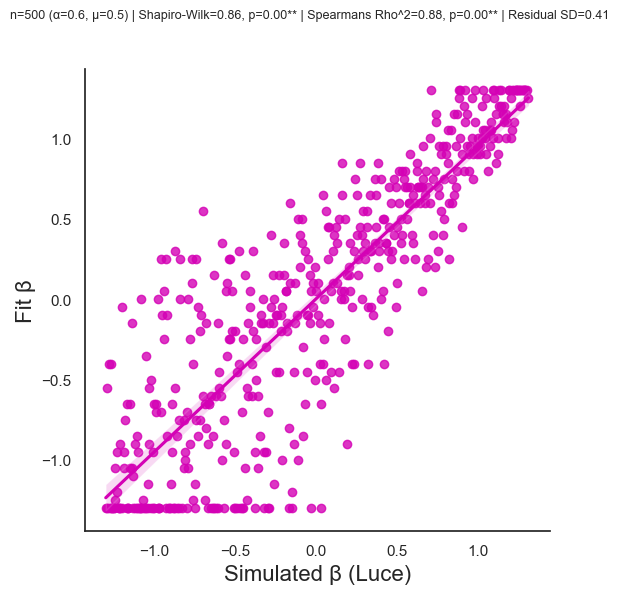

In [7]:
alphas = np.array([0.6])
betas = np.round(np.arange(-1.3, 1.31, 2.6/498), 2)
print("Number of Simulations:", len(alphas)*len(betas))
df = pd.DataFrame()

df_participants = pd.DataFrame(columns=["PID", 
                                        "Simulated Alpha", "Simulated Beta", 
                                        "Recovered Alpha", "Recovered Beta", 
                                        "Lottery Value", "Safe Value", 
                                        "Ambiguity", "Probability",
                                        "SV Lottery", "SV Safe",
                                        "Choice"])
recovered_betas = []
pid = 1
for p_alpha in alphas:
    for p_beta in betas:
        alpha_r, beta_r, df_participants = make_data_and_recover_LUCE(p_alpha, p_beta, pid, df_participants)
        recovered_betas.append(beta_r)
        print(pid, end = "\r")
        pid += 1   
filename = os.path.join(save_dir, "simulation3LUCE_cAvBcM-2trials.csv")
df_participants.to_csv(filename)

beta_x = betas.tolist() * alphas.shape[0]
fit_line = linregress(beta_x, recovered_betas)
fit_stat = spearmanr(beta_x, recovered_betas)
line_y = np.array(beta_x) * fit_line.slope + fit_line.intercept
residuals = np.array(beta_x) - np.array(recovered_betas)
print("Shapiro-Wilk Test of Normality:", shapiro(np.abs(residuals))[:])
print("Spearmans Rho^2:", fit_stat[:])
print("Residual SD:", np.std(residuals))
df["Simulated β (Luce)"] = beta_x
df["Fit β"] = recovered_betas
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.regplot(x = "Simulated β (Luce)", y = "Fit β", data = df, color = "#D401B5")
sns.despine(top = True)
ax.set_ylabel("Fit β", fontsize=16)
ax.set_xlabel("Simulated β (Luce)", fontsize=16)
plt.suptitle("n={5} (α=0.6, μ=0.5) | Shapiro-Wilk={0:.2f}, p={1:.2f}** | Spearmans Rho^2={2:.2f}, p={3:.2f}** | Residual SD={4:.2f}".format(shapiro(np.abs(residuals))[0], 
                                                                                                                                            shapiro(np.abs(residuals))[1], 
                                                                                                                                            fit_stat[0], fit_stat[1], 
                                                                                                                                            np.std(residuals),
                                                                                                                                            len(beta_x)),
                                                                                                                                            fontsize = 9)
fig_name = os.path.join(save_dir, "simulation3LUCE_cAvBcM-2trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)

### **Luce #2**
- Simulating across alpha and beta
- Mu held constant (0.5)

Shapiro-Wilk Test of Normality: (0.8687264919281006, 0.0)
Spearmans Rho^2: (0.8728684571151862, 0.0)
Residual SD: 0.4157365314047401
Saving to: Z:/data/SDDM\derivatives/simulations/crdm/simulation3\simulation3LUCE_vAvBcM-2trials.png


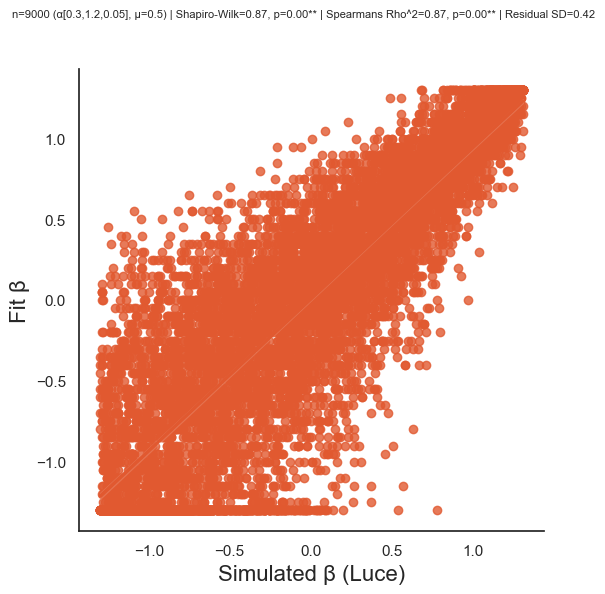

In [13]:
alphas = np.round(np.arange(0.3,  1.2,    0.05), 2)
betas = np.round(np.arange(-1.3, 1.31, 2.6/498), 2)
print("Number of Simulations:", len(alphas)*len(betas))
df = pd.DataFrame()

df_participants = pd.DataFrame(columns=["PID", 
                                        "Simulated Alpha", "Simulated Beta", 
                                        "Recovered Alpha", "Recovered Beta", 
                                        "Lottery Value", "Safe Value", 
                                        "Ambiguity", "Probability",
                                        "SV Lottery", "SV Safe",
                                        "Choice"])
recovered_betas = []
pid = 1
for p_alpha in alphas:
    for p_beta in betas:
        alpha_r, beta_r, df_participants = make_data_and_recover_LUCE(p_alpha, p_beta, pid, df_participants)
        recovered_betas.append(beta_r)
        print(pid, end = "\r")
        pid += 1
filename = os.path.join(save_dir, "simulation3LUCE_vAvBcM-2trials.csv")
df_participants.to_csv(filename) 

beta_x = betas.tolist() * alphas.shape[0]
fit_line = linregress(beta_x, recovered_betas)
fit_stat = spearmanr(beta_x, recovered_betas)
line_y = np.array(beta_x) * fit_line.slope + fit_line.intercept
residuals = np.array(beta_x) - np.array(recovered_betas)
print("Shapiro-Wilk Test of Normality:", shapiro(np.abs(residuals))[:])
print("Spearmans Rho^2:", fit_stat[:])
print("Residual SD:", np.std(residuals))
df["Simulated β (Luce)"] = beta_x
df["Fit β"] = recovered_betas
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.regplot(x = "Simulated β (Luce)", y = "Fit β", data = df, color = "#E15930")
sns.despine(top = True)
ax.set_ylabel("Fit β", fontsize=16)
ax.set_xlabel("Simulated β (Luce)", fontsize=16)
plt.suptitle("n={5} (α[0.3,1.2,0.05], μ=0.5) | Shapiro-Wilk={0:.2f}, p={1:.2f}** | Spearmans Rho^2={2:.2f}, p={3:.2f}** | Residual SD={4:.2f}".format(shapiro(np.abs(residuals))[0], 
                                                                                                                                                    shapiro(np.abs(residuals))[1], 
                                                                                                                                                    fit_stat[0], fit_stat[1], 
                                                                                                                                                    np.std(residuals),
                                                                                                                                                    len(beta_x)),
                                                                                                                                                    fontsize = 8)
fig_name = os.path.join(save_dir, "simulation3LUCE_vAvBcM-2trials.png")
print("Saving to: {}".format(fig_name))
plt.savefig(fig_name)